# Other computer vision problems

## Multi-label classification

### The data

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [4]:
df.iloc[:,0]
df.iloc[0,:]
# Trailing ‘:’s are always optional (in numpy, PyTorch, pandas, etc), so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

### End sidebar

### Constructing a data block

In [6]:
dblock = DataBlock()

In [7]:
dsets = dblock.datasets(df)

In [8]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [9]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [10]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [12]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('train/002844.jpg'), ['train'])

In [13]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [14]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [15]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [16]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

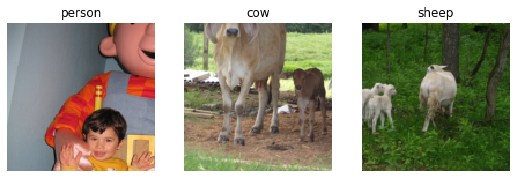

In [17]:
dls.show_batch(rows=1, cols=3)

### Creating a training loop

In [52]:
learn = cnn_learner(dls, resnet50)

In [55]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [56]:
activs[0]

tensor([-3.9925e-01, -7.5291e-02, -1.2857e+00,  1.5744e+00, -5.7591e-01, -1.5425e+00, -1.0145e+00, -1.9040e-01,  1.8246e-01,  6.6692e-01,  1.5874e+00,  1.3236e+00,  8.2713e-01,  1.5833e+00,
         1.4974e+00,  5.4996e+00, -2.9282e+00,  5.0139e-03,  1.3289e+00,  3.3174e+00], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).log().mean()

In [57]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0475, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [66]:
def one_epoch(lr):
    learn.model.train()
    for x,y in learn.dls.train:
        activs = learn.model(x)
        loss = loss_func(activs, y)
        loss.backward()
        for p in learn.model.parameters(): 
            p.data -= lr*p.grad.data
        learn.model.zero_grad()

In [69]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.720858,0.291352,0.731574,00:06
1,0.340106,0.139675,0.933406,00:06
2,0.214588,0.118188,0.939880,00:06
3,0.154529,0.107344,0.949821,00:06
4,0.121269,0.104563,0.950498,00:06


In [70]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.092994,0.104145,0.949980,00:07
1,0.091754,0.102735,0.950697,00:07
2,0.088727,0.103114,0.950578,00:07
3,0.087810,0.102556,0.950060,00:07
4,0.085980,0.102690,0.950618,00:07


## Regression

### Assemble the data

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
path.ls()

(#50) [Path('13.obj'),Path('07.obj'),Path('06.obj'),Path('13'),Path('10'),Path('02'),Path('11'),Path('01'),Path('20.obj'),Path('17')...]

In [ ]:
(path/'01').ls()

(#1000) [Path('01/frame_00281_pose.txt'),Path('01/frame_00078_pose.txt'),Path('01/frame_00349_rgb.jpg'),Path('01/frame_00304_pose.txt'),Path('01/frame_00207_pose.txt'),Path('01/frame_00116_rgb.jpg'),Path('01/frame_00084_rgb.jpg'),Path('01/frame_00070_rgb.jpg'),Path('01/frame_00125_pose.txt'),Path('01/frame_00324_rgb.jpg')...]

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('13/frame_00349_pose.txt')

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

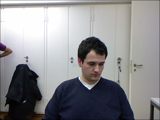

In [ ]:
im.to_thumb(160)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
get_ctr(img_files[0])

tensor([384.6370, 259.4787])

In [ ]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=get_ctr,
                 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)])

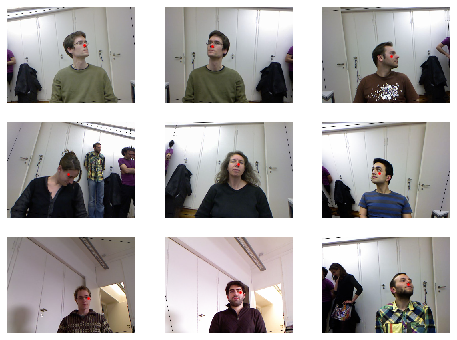

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
yb[0]

tensor([[0.0111, 0.1810]], device='cuda:5')

### Training a model

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [ ]:
def sigmoid_range(x, lo, hi): torch.sigmoid(x) * (hi-lo) + lo

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

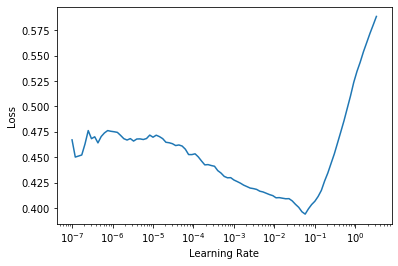

In [ ]:
learn.lr_find()

In [ ]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.045840,0.012957,00:36
1,0.006369,0.001853,00:36
2,0.003000,0.000496,00:37
3,0.001963,0.000360,00:37
4,0.001584,0.000116,00:36


In [ ]:
math.sqrt(0.0001)

0.01

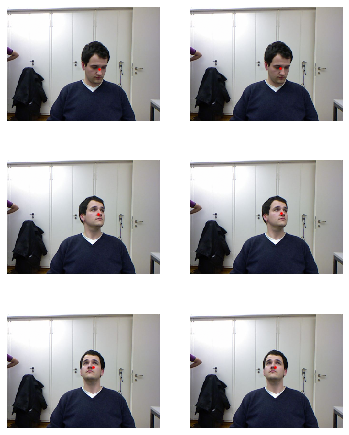

In [ ]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

## Conclusion